In [1233]:
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import PowerTransformer
from torchviz import make_dot
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import hiddenlayer as hl
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
from sklearn.metrics import mean_squared_error

In [1234]:
g = graphviz.Graph(engine='neato')

# Importing the data

In [1235]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    list = [int(i) for i in ls]

    return list

In [1236]:
def black_process(eval):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    # starting evaluation of 30 centipawns
    sum = 30

    i = 0
    res = []

    # iterating through centipawn losses
    for cpl in eval:

        # subtracting the cpl for white's moves
        if i % 2 ==0:
            sum -= cpl
            i += 1

        # adding the cpl for black's moves
        else:
            res.append([sum,cpl])
            sum+=cpl
            i+=1

    return numpy.array(res)

In [1237]:
def white_process(eval):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    # starting evaluation of 30 centipawns
    sum = 30

    i = 0
    res = []

    # iterating through centipawn losses
    for cpl in eval:

        # subtracting the cpl for white's moves
        if i % 2 ==0:
            res.append([sum,cpl])
            sum -= cpl
            i += 1

        # adding the cpl for black's moves
        else:
            sum+=cpl
            i+=1

    return numpy.array(res)

In [1238]:
# reading *some* of the data
dfs = []

players = ['andreikin, dmitry', 'anand, viswanathan', 'wang, hao', 'grischuk, alexander', 'karjakin, sergey','duda, jan-krzysztof', 'radjabov, teimour', 'dominguez perez, leinier','nakamura, hikaru', 'vachier-lagrave, maxime','aronian, levon','mamedyarov, shakhriyar', 'so, wesley','ding, liren', 'rapport, richard', 'nepomniachtchi, ian', 'giri, anish', 'firouzja, alireza', 'caruana, fabiano','carlsen, magnus','zelcic, robert','khotenashvili, bela', 'bischoff, klaus', 'hoffmann, asa','kaufman, lawrence','bellaiche, elise']

# reading the csvs
for player in players[3:]:
    df = pd.read_csv('blitz/'+player +'.csv')
    dfs.append(df)
df = pd.concat(dfs)


print(f"Total  games: {len(df)}")

# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

df = df[df['Eval'] != '']
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]


# converting the evaluation to a list
df['Eval'] = df['Eval'].apply( to_list)
df['WhiteEval'] = df['Eval'].apply( white_process )
df['BlackEval'] = df['Eval'].apply( black_process )

print(f"Evaluted games: {len(df['Eval'])}")

Total  games: 3397
Evaluted games: 454


In [1239]:
white_x = numpy.array(df['WhiteEval'])
white_length = numpy.array(df['WhiteEval'].apply(len))

black_x = numpy.array(df['WhiteEval'])
black_length = numpy.array(df['WhiteEval'].apply(len))

In [1240]:
# creating and fitting a power transformer for black and white
wpt = PowerTransformer()
white_y = numpy.concatenate(white_x)
wpt.fit(white_y)
white_transformed = wpt.transform(white_y)

bpt = PowerTransformer()
black_y = numpy.concatenate(black_x)
bpt.fit(black_y)
black_transformed = bpt.transform(black_y)

In [1241]:
def avg_cpl(white_processed):
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [1242]:
df['White_avg_cpl'] = df['WhiteEval'].apply( avg_cpl )

In [1243]:
df = df[df['Eval']!='']

White_avg_cpl
 0      7
 32     6
 12     5
 10     4
 33     4
       ..
-55     1
-56     1
-57     1
-60     1
 952    1
Length: 341, dtype: int64


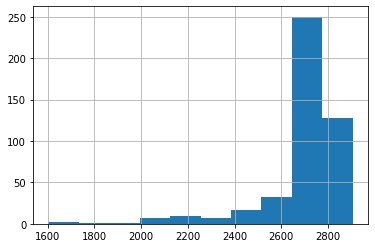

In [1244]:
df['WhiteELO'].hist()
print(df.value_counts('White_avg_cpl'))

<AxesSubplot:xlabel='WhiteELO', ylabel='[White_avg_cpl]'>

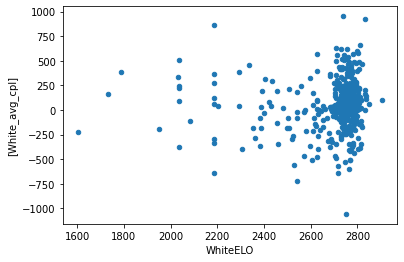

In [1245]:
df.plot.scatter(x='WhiteELO', y = ['White_avg_cpl'])

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WhiteELO', ylabel='White_avg_cpl'>

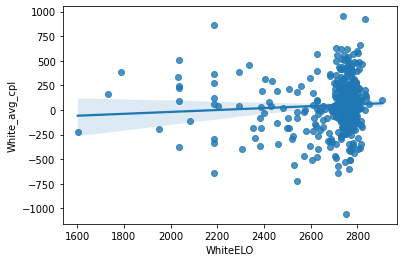

In [1246]:
plt.figure()
sns.regplot(df['WhiteELO'], df['White_avg_cpl'])

In [1247]:
# make a simple linear regression model.
X = np.array(df['White_avg_cpl'])
X = np.reshape(X, (len(X), 1))
y = np.array(df['WhiteELO'])
y = np.reshape(y, (len(y), 1))
regression = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

regression.fit(X_train,y_train)
regression.score(X_test,y_test)
#plt.scatter(y, pred_y)

y_pred = regression.predict(X_test)

In [1248]:
print(mean_squared_error(y_test, y_pred))

19828.679798604582


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

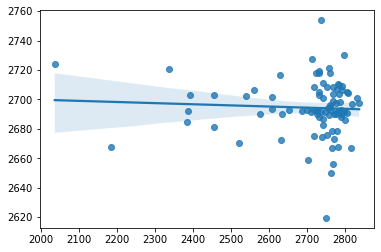

In [1249]:
plt.figure()
sns.regplot(y_test, y_pred)

In [1250]:
# need a function now to (effieciently) change these to lists of length list
white_transformed_array = [numpy.array(list(islice(iter(white_transformed), elem)))
        for elem in white_length]

black_transformed_array = [numpy.array(list(islice(iter(black_transformed), elem)))
        for elem in black_length]

In [1251]:
print(f"Unique evaluated games: {df['Game'].nunique()}")

Unique evaluated games: 431


# Preparing the data for the Neural Net

In [1252]:
# converting evaluations and length to tensors
white_evals = [torch.tensor(i, dtype = torch.float32) for i in white_transformed_array]
white_lengths = [len(tensor) for tensor in white_evals]

black_evals = [torch.tensor(i, dtype = torch.float32) for i in black_transformed_array]
black_lengths = [len(tensor) for tensor in black_evals]

In [1253]:
# Padding my sequences - not sure why batch first works, but it does
#inputs = torch.nn.utils.rnn.pad_sequence(evals, batch_first=True, padding_value=0.0)

In [1254]:
#inputs_array = numpy.array(inputs.tolist())

In [1255]:
#print(inputs.shape)

In [1256]:
#inputs_list =inputs.tolist()

# normalizing... a bit hacky
#inputs_array = (numpy.array(inputs_list) - numpy.array(inputs_list).mean())/ numpy.linalg.norm(numpy.array(inputs_list))

In [1257]:
def normalize(array):
    '''
    :param array:
    :return:
    '''
    return (array - array.mean())/array.std()

def denormalize(array, value):
    '''
    :param array:
    :param value:
    :return:
    '''
    return value*array.std() + array.mean()

In [1258]:
#print(df['WhiteELO'].value_counts())

In [1259]:
from sklearn import preprocessing

In [1260]:
white_elo_arr = numpy.array(df['WhiteELO'])


In [1261]:
welopt = PowerTransformer()
white_elo_arr = np.reshape(white_elo_arr, (len(white_elo_arr),1))
welopt.fit(white_elo_arr)
white_elo_transformed = welopt.transform(white_elo_arr)

In [1262]:
print(white_elo_arr)

[[2632]
 [2795]
 [2784]
 [2709]
 [2750]
 [2503]
 [2736]
 [2716]
 [2719]
 [2731]
 [2703]
 [2764]
 [2795]
 [2754]
 [2766]
 [2736]
 [2498]
 [2772]
 [2722]
 [2772]
 [2749]
 [2543]
 [2752]
 [2688]
 [2777]
 [2777]
 [2792]
 [2709]
 [2775]
 [2741]
 [2433]
 [2752]
 [2727]
 [2752]
 [2541]
 [2681]
 [2581]
 [2730]
 [2653]
 [2731]
 [2710]
 [2795]
 [2774]
 [2832]
 [2798]
 [2766]
 [2760]
 [2772]
 [2752]
 [2541]
 [2799]
 [2779]
 [2771]
 [2743]
 [2456]
 [2757]
 [2785]
 [2773]
 [2754]
 [2764]
 [2743]
 [2753]
 [2613]
 [2385]
 [2709]
 [2782]
 [2630]
 [2723]
 [2688]
 [2783]
 [2772]
 [2760]
 [2509]
 [2773]
 [2606]
 [2700]
 [2760]
 [2786]
 [2700]
 [2779]
 [2727]
 [2723]
 [2777]
 [2783]
 [2756]
 [2789]
 [2738]
 [2628]
 [2717]
 [2628]
 [2734]
 [2352]
 [2784]
 [2694]
 [2731]
 [2629]
 [2628]
 [2628]
 [2734]
 [2640]
 [2622]
 [2758]
 [2729]
 [2777]
 [2717]
 [2620]
 [2608]
 [2819]
 [2597]
 [2729]
 [2700]
 [2608]
 [2717]
 [2729]
 [2731]
 [2699]
 [2793]
 [2731]
 [2724]
 [2738]
 [2422]
 [2724]
 [2788]
 [2738]
 [2725]


In [1263]:
print(len(white_elo_transformed))

454


(array([ 52.,  28.,  62., 138., 135.,  31.,   6.,   1.,   0.,   1.]),
 array([-2.23706627, -1.57733336, -0.91760046, -0.25786756,  0.40186535,
         1.06159825,  1.72133115,  2.38106406,  3.04079696,  3.70052986,
         4.36026277]),
 <BarContainer object of 10 artists>)

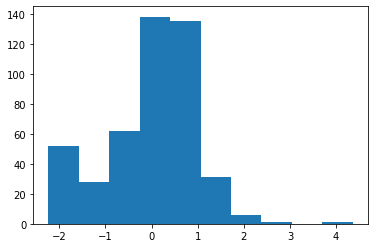

In [1264]:
plt.hist(white_elo_transformed)

In [1265]:
# Converting White and Black's ELOs to tensors


#white_elo = normalize(white_elo_arr)

#print(white_elo)
white_elo = [torch.tensor(i, dtype = torch.float32) for i in white_elo_transformed]



black_elo = numpy.array(df['BlackELO'])
black_elo = [torch.tensor(i, dtype = torch.float32) for i in black_elo]


# splitting into train and test
#lengths_train, lengths_test,white_eval_train, white_eval_test, black_eval_train, black_eval_test, black_train, black_test, white_train, white_test  = train_test_split(lengths, white_evals, black_evals, black_elo, white_elo, test_size=0.2,random_state=0, shuffle = True)
white_eval_train, white_eval_test, black_eval_train, black_eval_test, black_train, black_test, white_train, white_test  = train_test_split(white_evals, black_evals, black_elo, white_elo, test_size=0.2,random_state=1, shuffle = True)

(array([ 52.,  28.,  62., 138., 135.,  31.,   6.,   1.,   0.,   1.]),
 array([-2.23706627, -1.57733336, -0.91760046, -0.25786756,  0.40186535,
         1.06159825,  1.72133115,  2.38106406,  3.04079696,  3.70052986,
         4.36026277]),
 <BarContainer object of 10 artists>)

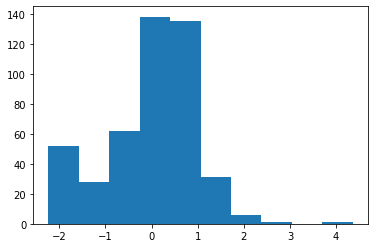

In [1266]:
plt.hist(white_elo_transformed)

(array([  2.,   1.,   1.,   7.,   9.,   7.,  17.,  32., 250., 128.]),
 array([-6.4147788 , -5.64982759, -4.88487638, -4.11992516, -3.35497395,
        -2.59002274, -1.82507153, -1.06012031, -0.2951691 ,  0.46978211,
         1.23473332]),
 <BarContainer object of 10 artists>)

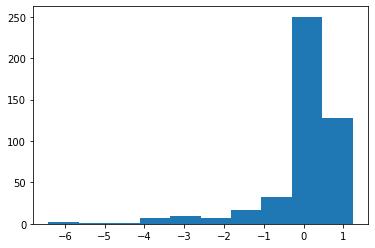

In [1267]:
plt.hist(normalize(white_elo_arr))

In [1268]:
# zipping the elo together with the evaluations
# train_data_zip = list(zip(white_eval_train, black_eval_train, white_train))
# test_data_zip = list(zip(white_eval_test, black_eval_test, white_test))

train_data_zip = list(zip(white_eval_train, white_train))
test_data_zip = list(zip(white_eval_test, white_test))

In [1269]:
black_elo = torch.stack(black_elo)
white_elo = torch.stack(white_elo)

# Creating the Neural Net

In [1270]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.rnn = nn.RNN(input_size, hidden_size, no_layers, batch_first = True, bias = True)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):

        out, _ = self.rnn(x)
        output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)
        # shape batches, seq_length, hidden_size


        out = [output[e, i-1,:].unsqueeze(0)for e, i in enumerate(lengths)]
        out = torch.cat(out, dim = 0)
        #print(out.shape)
        #print("Linear weights", self.fc.weight)
        out = self.fc(out)
        out = self.final(out)
        #print(out.shape)
        out = out[:,0]

        return out


    #def init_hidden(self):
    #    return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

# need to figure out exactly how the dimensions changed


In [1271]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    # remove that eventually. I'm going to need to make my dataset a tuple with evals and elo
    #def __init__(self):

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        #black_data = [item[1] for item in batch]
        target = [item[1] for item in batch]
        white_lens = [i.shape[0] for i in white_data]
        #black_lens = [i.shape[0] for i in black_data]


        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)

        # black_data = torch.nn.utils.rnn.pad_sequence(black_data, batch_first=True,padding_value = 0)
        # black_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(black_data,batch_first = True, lengths=black_lens,enforce_sorted=False)


        target = torch.tensor(target,dtype=torch.float32)
        return [white_evals_packed, target]

In [1272]:
input_size = 2
hidden_size = 140
no_layers = 4
batch_size = 8

In [1273]:
# (defining my model)
model = MyRNN(input_size, hidden_size, no_layers)
collate = MyCollator()

In [1274]:
print(model.parameters)

<bound method Module.parameters of MyRNN(
  (rnn): RNN(2, 140, num_layers=4, batch_first=True)
  (fc): Linear(in_features=140, out_features=1, bias=False)
  (final): Tanh()
)>


# Training the model

In [1275]:
writer = SummaryWriter('runs/h45l4-2')

In [1276]:
# # add to loop
# running_loss  = 0
# running_loss += loss.item()
# writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps +i)
# writer.add_scalar('accuracy', running_loss / 100, epoch * n_total_steps +i)

In [1277]:
data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True ,collate_fn=collate)

In [1278]:
learning_rate = .2

In [1279]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1280]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [1281]:
# OK I've figured out the issue, I also need the sequence length for the RNN

In [1282]:
avg_losses = []
epochs = []
avg_loss = 1

for epoch in range(25):

    if (epoch+1) % 5 ==0:
        learning_rate /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    losses = []

    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        #black_evals = black_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        #print(outputs)
        #print(outputs.shape, elo.shape)
        loss = criterion(outputs,elo)
        # optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i+=1

    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',avg_loss, epoch)
    avg_losses.append(avg_loss)
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')


writer.close()

Epoch 1 step 47 - Learning Rate : 0.2- Avg Loss: 1.110109 - Change in loss: 1.1101088737664015
Epoch 2 step 47 - Learning Rate : 0.2- Avg Loss: 1.029197 - Change in loss: 0.9271137484896071
Epoch 3 step 47 - Learning Rate : 0.2- Avg Loss: 1.056684 - Change in loss: 1.0267071376682078
Epoch 4 step 47 - Learning Rate : 0.2- Avg Loss: 1.034652 - Change in loss: 0.9791495723064966
Epoch 5 step 47 - Learning Rate : 0.1- Avg Loss: 1.047380 - Change in loss: 1.012301499175306
Epoch 6 step 47 - Learning Rate : 0.1- Avg Loss: 1.048540 - Change in loss: 1.001108282730968
Epoch 7 step 47 - Learning Rate : 0.1- Avg Loss: 1.030554 - Change in loss: 0.982846056105278
Epoch 8 step 47 - Learning Rate : 0.1- Avg Loss: 1.021637 - Change in loss: 0.9913477132680806
Epoch 9 step 47 - Learning Rate : 0.1- Avg Loss: 1.034750 - Change in loss: 1.0128347976074057
Epoch 10 step 47 - Learning Rate : 0.05- Avg Loss: 1.009087 - Change in loss: 0.975199619518898
Epoch 11 step 47 - Learning Rate : 0.05- Avg Loss: 1

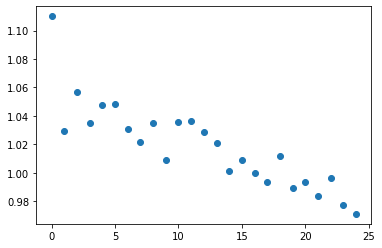

In [1283]:
plt.scatter(epochs, avg_losses)

## Test data

In [1284]:
model =model.eval()

In [1285]:
model.to(device)

MyRNN(
  (rnn): RNN(2, 140, num_layers=4, batch_first=True)
  (fc): Linear(in_features=140, out_features=1, bias=False)
  (final): Tanh()
)

In [1286]:
test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [1287]:
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader:
    #print("evals",evals.shape)
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    #print(f'Model prediction : {output} \n ELO : {elo} \n MSE : {loss}')
    losses.append(loss.item())
print(f'Average loss : {stats.mean(losses)}')

Average loss : 0.8955340134016896


In [1288]:
model(evals)

tensor([-0.2037], grad_fn=<SelectBackward0>)

In [1289]:
print(elos)

[-0.21318089962005615, 0.014115694910287857, 0.6733883023262024, -0.059384189546108246, 0.5981887578964233, 1.4642105102539062, 0.7116910815238953, -0.47873079776763916, 0.3834530711174011, 0.7897300720214844, -0.13061243295669556, -2.2000741958618164, 0.29859641194343567, -0.08814433217048645, 0.18415005505084991, 0.3153572082519531, 0.3153572082519531, -0.0302606038749218, 0.21634088456630707, 1.2324891090393066, -1.2802400588989258, -2.0521774291992188, 0.04416690021753311, 0.561281144618988, 0.24893581867218018, 0.8900245428085327, 0.7504698038101196, -2.2000741958618164, 1.3005249500274658, 0.21634088456630707, -0.33132070302963257, -1.799088478088379, 0.561281144618988, 0.41814127564430237, -1.182690143585205, 0.7897300720214844, 0.561281144618988, -1.7198941707611084, -1.1605983972549438, -0.17228662967681885, -0.13061243295669556, -0.8960787057876587, 0.21634088456630707, 0.561281144618988, 0.1054101437330246, -1.369218349456787, -0.059384189546108246, 0.400743305683136, -0.102

In [1290]:
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))

In [1291]:
elos = welopt.inverse_transform(elos)
outputs = welopt.inverse_transform(outputs)

In [1292]:
print(mean_squared_error(elos,outputs))

21101.57046473561


In [1293]:
# de-normalize the elos - predicted and actual

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

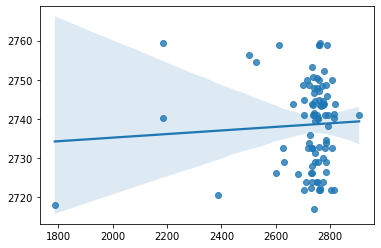

In [1294]:
sns.regplot(elos,outputs)

# Plotting the neural net architecture

In [1295]:
print(max(outputs))
print(min(outputs))

[2759.34783641]
[2716.83066607]


In [1296]:
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
#traced_script_module = torch.jit.trace(model, example)

In [1297]:
params =dict(model.named_parameters())

In [1298]:
dot = make_dot(output, params=params, show_attrs=False, show_saved=False)

In [1299]:
dot.render("rnn_torchviz3", format="pdf", engine= 'neato') # doesn't seem to work great with padded & packed input...

'rnn_torchviz3.pdf'

# Visualization

In [1300]:
writer = SummaryWriter('runs/run1')